# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

# Importación de Librerías

In [1]:
import pandas as pd
import numpy as np
from random import seed
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#Modelos
import sklearn.neural_network
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
seed(0)

# Preprocesamiento de Datos

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/sms-spam.csv",
    sep = ',',
    decimal = '.',
    encoding='latin-1')

data.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


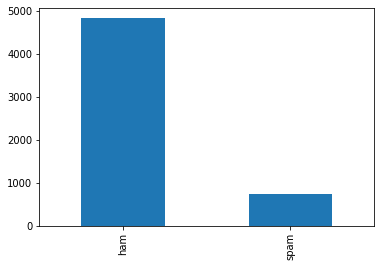

In [5]:
data.type.value_counts().plot.bar();

###  Aplicación de Stemmer

Debido a la presencia de afijos morfológicos en las palabras, se debe hacer algo parecido a una traducción a una manera más
compacta de la  palabra, esto nos deja los datos de una manera mas concisa. Se decidide usar la herramienta PorterStemmer 
de la librería sklearn

In [4]:
stemmer = PorterStemmer()
data['stemmed'] = data.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))
data.head(10)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? U R entitl to...


### Bag of Words

A continuación creamos un bag of words con la frecuencia de cad palabra en un mensaje

In [6]:
count_vect = CountVectorizer(analyzer='word',lowercase=True,stop_words='english',binary=True,min_df=5)

## Aplica la función al texto
dtm = count_vect.fit_transform(data.stemmed)

## Las filas contienen los mensajes y las clomunas los términos
dtm.shape

(5574, 1540)

In [7]:
vocabulary = count_vect.get_feature_names()
len(vocabulary)

1540

In [8]:
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

for i, x in enumerate(dtm2words(dtm, vocabulary, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])):
    print('Org: ', data.text[i])
    print('Mod: ', ' '.join(x))
    print('')

Org:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mod:  avail bugi cine got great la onli point wat world

Org:  Ok lar... Joking wif u oni...
Mod:  joke lar ok wif

Org:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mod:  appli comp cup entri final free question rate receiv std text txt win wkli

Org:  U dun say so early hor... U c already then say...
Mod:  alreadi dun earli say

Org:  Nah I don't think he goes to usf, he lives around here though
Mod:  don goe live nah think usf

Org:  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
Mod:  50 darl freemsg fun hey like ok send std week word xxx

Org:  Even my brother is not like to speak with me. They treat me like aids patent.
Mod:  brother like speak treat

Or

### División de la Data

In [9]:
data['type'][data['type']=='spam'] = 1
data['type'][data['type']=='ham'] = 0
X  = dtm
y= np.array(data.type,dtype='int64')

print("Las dimensiones de X:",X.shape)
print("Las dimensiones de y:",y.shape)

Tamaño X: (5574, 1540)
Tamaño y: (5574,)


### Naive Bayes

Se decide aplicar la herramieta BernoulliNB de la librería sklearn siguiendo un ejemplo dado por el profesor en la
documentación de sus cursos, se puede encontrar en el siguiente link:
https://jdvelasq.github.io/courses/notebooks/sklearn/bayes/02-filtrado-de-mensajes-sms.html

In [10]:
##
## Se crea un clasificador Naive Bayes (NB)
##
search = BernoulliNB()

##
## Se entrena el clasificador
##
scores = cross_val_score(search, X, y, cv=5,scoring = 'precision')
print('Precision Promedio:',np.mean(scores))

Precision Promedio: 0.9796719707127352


# Regresión Logística

### Ajuste de parámetros

Para la elección de los parámetros que nos dejen las mejores métricas(en este caso: precision) se decide usar la herramienta GridSearchCV de la librería sklearn

In [11]:
params = {'penalty': ['l1', 'l2'],'C': [0.001,0.01,0.1,1,10,100]}
log_reg = LogisticRegression()
search = GridSearchCV(log_reg, params,cv=5,scoring='precision')
search.fit(X,y)
print(search.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'C': 0.01, 'penalty': 'l2'}


### Entrenamiento y Validación

In [12]:
log_reg =  LogisticRegression(C=search.best_params_['C'],penalty =search.best_params_['penalty'] )
scores = cross_val_score(log_reg, X, y, cv=5,scoring = 'precision')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
log_reg = log_reg.fit(X_train,y_train)
y_predict = log_reg.predict(X_test)
print(confusion_matrix(y_test,y_predict))
print(np.mean(scores))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[1198    0]
 [ 147   49]]
1.0


# Red Neuronal
### Selección de Capas Ocultas

Por motivos de recursos a la hora del procesamiento y computo, primero vamos a buscar la distribución de las capas ocultas antes de hacer la busqueda de los demás parámetros. Se decide usar la herramienta GridSearchCV de la librería sklearn 

In [13]:
from sklearn.model_selection import GridSearchCV
import sklearn.neural_network
params = {"hidden_layer_sizes": [(6,),(7,),(8,),(10,)]}
nn = sklearn.neural_network.MLPRegressor()
search = GridSearchCV(nn, params,cv=5)
search.fit(X,y)
print(search.best_params_)

{'hidden_layer_sizes': (10,)}


### Selección de Otros Parámetros
Una vez sabiendo el número de capas ocultas, seguimos con la busqueda de los demás parámetros faltantes. Se decide usar la herramienta GridSearchCV de la librería sklearn 

In [14]:
params = {'hidden_layer_sizes': [(10,)],
          'activation': ['logistic','identity','relu','tanh'], 
          'solver': ['sgd','adam','lbfgs'], 'alpha': [0.00005,0.0005,0.1],
          'learning_rate':['invscaling','constant','adaptive'],
          'max_iter' : [1000] }
nn = sklearn.neural_network.MLPClassifier()
search = GridSearchCV(nn, params,cv=5,scoring='precision')
search.fit(X,y)
print(search.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: U

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: U

{'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling', 'max_iter': 1000, 'solver': 'adam'}


In [ ]:
{'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling', 'max_iter': 1000, 'solver': 'adam'}

### Entrenamiento  y Validación

In [16]:
nn =  sklearn.neural_network.MLPClassifier(
                hidden_layer_sizes = (10,), 
                activation = 'logistic', 
                solver = 'adam',     
                alpha = 0.1,            
                learning_rate = 'invscaling',
                max_iter = 1000)

scores = cross_val_score(nn, X, y, cv=5,scoring = 'precision')
print("Precision: ",np.mean(scores))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
nn = nn.fit(X_train,y_train)
y_predict = nn.predict(X_test)
print(confusion_matrix(y_test,y_predict))

Precision:  0.99258699481733
[[1195    3]
 [  26  170]]


### Conclusión 

Podemos ver que la métrica precisión de los modelos es muy alta por lo tanto es muy díficil inferir cual de los dos modelos se comporta mejor, por eso debemos mirar sus matrices de Confusión para poder tener mejores argumentos

REGRESION | RED NEURONAL
:--------:| :-------:
VP: 1198  | VP: 1195
VN:  147  | VN:  26
FP: 0     | FP: 3 
FN: 49    | FN: 170

Vemos que la regresión se comporta mejor para los mensajes no considerados como spam, aún cuando en general la red neuronal se comporta mejor